<a href="https://colab.research.google.com/github/SandeepJosyula/NeuralNetworks/blob/master/SJ_NLP_Project1_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - NLP - Sequential Models

## Sentiment Classification
**Objective**
The objective of this project is to build a text classification model that analyses the customer's sentiments
based on their reviews in the IMDB database. The model uses a complex deep learning model to build an
embedding layer followed by a classification algorithm to analyze the sentiment of the customers.

**Dataset**

The Dataset of 50,000 movie reviews from IMDB, labelled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocab size of 10,000. As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word

**Overview**
- Dataset of 50,000 movie reviews from IMDB, labeled by sentiment positive (1) or negative (0)
- Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).
- For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
- As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Command to import data
- `from tensorflow.keras.datasets import imdb`



## Import Libraries

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.datasets import imdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

In [3]:
from keras        import models, regularizers, layers, optimizers, losses, metrics
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, TimeDistributed
from keras.utils  import np_utils, to_categorical

### Import the data (2 Marks)
- Use `imdb.load_data()` method
- Get train and test set
- Take 10000 most frequent words

In [4]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [5]:
print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("~"*100)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)

train_data  (25000,)
train_labels  (25000,)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
test_data  (25000,)
test_labels  (25000,)


### Print shape of features & labels (2 Marks)
 - Number of reviews
 - Number of words in each review
 - Number of labels
 - Maximum review length
 - Number of categories


**Combine train and test data in to single np array to do the pre-processing**

In [6]:
data = np.concatenate((train_data, test_data), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

print("Number of reviews:", data.shape)
print("Label categories:", np.unique(targets))
print("Number of unique words:", len(np.unique(np.hstack(data))))
print("Maximum count of words in a review: ", max([len(sequence) for sequence in data]))

Number of reviews: (50000,)
Label categories: [0 1]
Number of unique words: 9998
Maximum count of words in a review:  2494


In [7]:
length = [len(i) for i in data]
print("Maximum review length:", np.max(length))
print("Average Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))

Maximum review length: 2494
Average Review length: 234.75892
Standard Deviation: 173.0


In [8]:
#print the label
print("Label:", targets[100])
# print the data 
print(data[100])

Label: 0
[1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]


### Decode the feature value to get original sentence (2 Marks)

First, retrieve a dictionary that contains mapping of words to their index in the IMDB dataset

In [9]:
# See an actual review in words
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)

word_index = imdb.get_word_index()

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

Now use the dictionary to get the original words from the encodings, for a particular sentence

In [10]:
pick_idx = 123  # Pick 123rd sentence

print("Label:", train_labels[pick_idx])

# build the sentence by decoding each word and concatenate it
decoded_review = ' '.join([reverse_word_index.get(i - 3, '$') for i in train_data[pick_idx]])

print(textwrap.fill(decoded_review,100))

Label: 1
$ beautiful and touching movie rich colors great settings good acting and one of the most charming
movies i have seen in a while i never saw such an interesting setting when i was in china my wife
liked it so much she asked me to $ on and rate it so other would enjoy too


### Print value of any one feature and it's label (2 Marks)

In [11]:
pick_idx = 1500 # Pick 1500th review
print("Label:", train_labels[pick_idx])
# build the sentence by decoding each word and concatenate it
decoded_review = ' '.join([reverse_word_index.get(i - 3, '$') for i in train_data[pick_idx]])

print(textwrap.fill(decoded_review,100))

Label: 1
$ one of the things about the film that $ my heart strings was that dry fly fishing was a major part
of the scene i have occasionally carried out my times of dry fly fishing having tied my own flies
and being accompanied by my brother and my father we spend a day on one river or another seeking to
$ the ever $ brown $ to rise and take the fly that has been offered to them br br when we had
occasions like this any differences between us disappeared and any of the $ of the world $ away to
be replaced by the glory of being absorbed in the activity and the surroundings of the place we were
in br br this was one of the amazing things that was portrayed to me in the film as the minister and
his two sons norman and $ carried out the ritual for there is something $ about fly fishing as there
is something $ about so many $ you can't just start casting your fishing line and hope for the best
you have to $ yourself to the place you are in you have to $ the surface of the water considerin

### Pad each sentence to be of same length (2 Marks)
- Take maximum sequence length as 300

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(data,maxlen=300)
print("Maximum count of words in a review in original review dataset: ", max([len(sequence) for sequence in data]))
print("Maximum count of words in a review in padded dataset: ", max([len(sequence) for sequence in X]))

Maximum count of words in a review in original review dataset:  2494
Maximum count of words in a review in padded dataset:  300


### Split in to train and test sets
 - Train set containing 40000 reviews
 - Test set containing 10000 reviews
 - Within the Train set, 10000 reviews are moved in to validation set, and rest 30000 for training

In [13]:
x_train = X[10000:]
x_test = X[:10000]
y_train = targets[10000:]
y_test = targets[:10000]

In [14]:
# Set a VALIDATION set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (10000, 300)
partial_x_train  (30000, 300)
y_val  (10000,)
partial_y_train  (30000,)


### Define model (10 Marks)
- Define a Sequential Model
- Add Embedding layer
  - Embedding layer turns positive integers into dense vectors of fixed size
  - `tensorflow.keras` embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unique integer number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn LabelEncoder.
  - Size of the vocabulary will be 10000
  - Give dimension of the dense embedding as 100
  - Length of input sequences should be 300
- Add LSTM layer
  - Pass value in `return_sequences` as True
- Add a `TimeDistributed` layer with 100 Dense neurons
- Add Flatten layer
- Add Dense layer

In [15]:
# NN MODEL

vocabsize = 10000
embed_dim = 100
lstm_out = 100

# Use of DROPOUT
model = models.Sequential()
model.add(Embedding(vocabsize, embed_dim,input_length = X.shape[1],name="EmbeddingLayer"))
model.add(SpatialDropout1D(0.4,name="SpatialDropoutLayer"))
model.add(LSTM(lstm_out,dropout=0.2,recurrent_dropout=0.2,return_sequences=True,name="LSTMLayer"))
model.add(TimeDistributed(Dense(100),name="TimeDistributedLayer"))
model.add(Flatten(name="FlattenLayer"))
model.add(Dense(1,activation='sigmoid',name="FinalDenseLayer"))

### Compile the model (2 Marks)
- Use Optimizer as Adam
- Use Binary Crossentropy as loss
- Use Accuracy as metrics

In [16]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

### Print model summary (2 Marks)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EmbeddingLayer (Embedding)   (None, 300, 100)          1000000   
_________________________________________________________________
SpatialDropoutLayer (Spatial (None, 300, 100)          0         
_________________________________________________________________
LSTMLayer (LSTM)             (None, 300, 100)          80400     
_________________________________________________________________
TimeDistributedLayer (TimeDi (None, 300, 100)          10100     
_________________________________________________________________
FlattenLayer (Flatten)       (None, 30000)             0         
_________________________________________________________________
FinalDenseLayer (Dense)      (None, 1)                 30001     
Total params: 1,120,501
Trainable params: 1,120,501
Non-trainable params: 0
______________________________________________

### Fit the model (2 Marks)

In [18]:
# FIT / TRAIN model

NumEpochs = 10
BatchSize = 500

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/10
60/60 [==============================] - 28s 466ms/step - loss: 0.5007 - accuracy: 0.7308 - val_loss: 0.3244 - val_accuracy: 0.8628
Epoch 2/10
60/60 [==============================] - 27s 450ms/step - loss: 0.2586 - accuracy: 0.8943 - val_loss: 0.2878 - val_accuracy: 0.8789
Epoch 3/10
60/60 [==============================] - 27s 452ms/step - loss: 0.1963 - accuracy: 0.9224 - val_loss: 0.3105 - val_accuracy: 0.8721
Epoch 4/10
60/60 [==============================] - 27s 451ms/step - loss: 0.1694 - accuracy: 0.9326 - val_loss: 0.3187 - val_accuracy: 0.8808
Epoch 5/10
60/60 [==============================] - 27s 452ms/step - loss: 0.1361 - accuracy: 0.9487 - val_loss: 0.3518 - val_accuracy: 0.8782
Epoch 6/10
60/60 [==============================] - 27s 443ms/step - loss: 0.1025 - accuracy: 0.9621 - val_loss: 0.3797 - val_accuracy: 0.8755
Epoch 7/10
60/60 [==============================] - 27s 443ms/step - loss: 0.0859 - accuracy: 0.9679 - val_loss: 0.4458 - val_accuracy: 0.8665

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

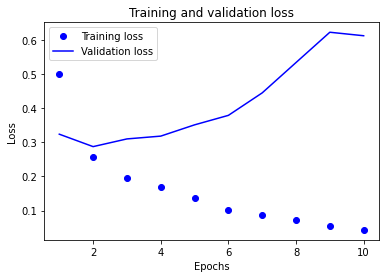

In [19]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

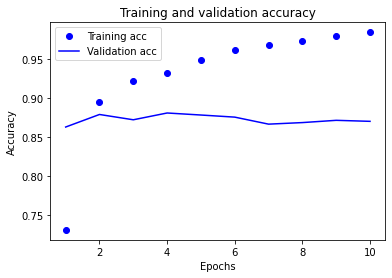

In [20]:
# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate model (2 Marks)

In [21]:
#### Add your code here ####
model.evaluate(x_test, y_test)

313/313 [==============================] - 21s 67ms/step - loss: 0.6031 - accuracy: 0.8650


[0.60311359167099, 0.8650000095367432]

### Predict on one sample (2 Marks)

In [22]:
def preprocess(sample_text):
  sample_input = sample_text.split(' ')
  sample_predict = np.zeros(300)
  sample_predict = sample_predict.astype('int')
  idx = 299
  for txt in sample_input:
    tmp = word_index.get(txt,0)
    sample_predict[idx] = tmp
    print(txt," - ", tmp)
    idx = idx - 1
  print("Sample Text encoded: ", sample_predict)
  sample_predict = sample_predict.astype('int')

  # build the final array for predicting using the model
  final_pred[0]=sample_predict    #copy the new values to first row
  print("Final input to model to predict, shape:", final_pred.shape)
  return final_pred

In [23]:
sample_text = "This is a good movie and a very nice story"
final_pred = x_test[:1]         #copy the same structure as test dataset
final_pred = preprocess(sample_text)
sentiment = model.predict(final_pred,batch_size=1)[0]
print("Sentiment Assessment value (0-Negative <--> 1.Positive): ", sentiment)
if(sentiment < 0.5):
    print("negative")
else:
    print("positive")

This  -  0
is  -  6
a  -  3
good  -  49
movie  -  17
and  -  2
a  -  3
very  -  52
nice  -  324
story  -  62
Sample Text encoded:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  